In [2]:
#概要
#英語の入力から翻訳を作成する
#colabで動かすことを想定しています。

#参考にしたもの
#1. Udemy 「自然言語処理とチャットボット: AIによる文章生成と会話エンジン開発」より、文章生成・Seq2Seqの講座
#https://www.udemy.com/course/ai-nlp-bot/?deal_code=JPA8DEAL2PERCENTAGE&aEightID=s00000016735001


#2. tensorflowのチュートリアル
#https://www.tensorflow.org/tutorials

from __future__ import absolute_import, division, print_function, unicode_literals

#point
#kerasは、tensorflowの中のkerasを使う
import tensorflow as tf
from tensorflow import keras  

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
#from keras.utils import plot_model
import unicodedata
import re
import numpy as np
import os
import io
import time
import zipfile

ModuleNotFoundError: No module named 'tensorflow'

In [1]:
tf.__version__

NameError: name 'tf' is not defined

In [4]:
#英語と日本語のデータを取得する
path = "./jpn.txt"

In [5]:
#fileからデータを読み込む
def preprocess_sentence(w):
    w = w.lower().strip()
    return w

def create_dataset(path, num_examples = None):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

#ファイルからデータを読み込む
en_datas , jp_datas ,_= create_dataset(path)
print(en_datas[:10])
print(jp_datas[:10])

NameError: name 'io' is not defined

In [11]:
len(en_datas), len(jp_datas)

#訓練のため30000行を抽出
#本来は400000行以上のデータがあるが、すべてを読み込むとone-hot表現に変換するとき、colab環境ではメモリ不足で強制終了してしまう。
#よって、この例では30000行分のデータを読み込んでいる

limit_data = 30000
en_datas = en_datas[0:limit_data]
jp_datas = jp_datas[0:limit_data]
jp_datas = list(jp_datas)

#jp_datasに終わりと開始を追加する(翻訳のところで文章の開始を終わりを判定するため)
for i  in  range(len(jp_datas)):
  #print(data)
  a = jp_datas[i]
  jp_datas[i] = "\t" + a + "\n"

print(jp_datas[:5])

jp_datas = tuple(jp_datas)

['\t行け。\n', '\t行きなさい。\n', '\tこんにちは。\n', '\tもしもし。\n', '\tやっほー。\n']


In [12]:
def max_length(tensor):
    return max(len(t) for t in tensor)

en_max_length = max_length(en_datas)
jp_max_length = max_length(jp_datas)

en_max_length, jp_max_length

(32, 40)

In [13]:
#one-hotに置き換える
chars = []
for word in en_datas:  # 
  chars +=word

for word in jp_datas:  # 
  chars +=word

chars += "\t\n"  # タブと改行を追加
chars_list = sorted(list(chars))  # 文字列をリストに変換してソートする
chars_list = set(chars_list)
print(chars_list)
print(len(chars_list))


# インデックスと文字で辞書を作成
char_indices = {}  # 文字がキーでインデックスが値
for i, char in enumerate(chars_list):
    char_indices[char] = i
indices_char = {}  # インデックスがキーで文字が値
for i, char in enumerate(chars_list):
    indices_char[i] = char
    
print(char_indices)
print(indices_char)

#one-hotの領域
n_char = len(chars_list)  # 文字の種類の数
n_sample = len(jp_datas) - 1  # サンプル数


#初期化(ベクトル化する)
x_encoder = np.zeros((n_sample, en_max_length, n_char), dtype=np.bool)  # encoderへの入力
x_decoder = np.zeros((n_sample, jp_max_length, n_char), dtype=np.bool)  # decoderへの入力
t_decoder = np.zeros((n_sample, jp_max_length, n_char), dtype=np.bool)  # decoderの正解


#one-hotに置き換える
#本当は単語埋め込み (Word embeddings)を使ったほうが、メモリ容量など抑えられるが、
#今回は、簡単に実装できそうなone-hotを選択した
#参考URL
#https://www.tensorflow.org/tutorials/text/word_embeddings
for i in range(n_sample):
    x_sentence = en_datas[i]
    t_sentence = jp_datas[i]
    for j, char in enumerate(x_sentence):
        x_encoder[i, j, char_indices[char]] = 1  # encoderへの入力をone-hot表現で表す

    for j, char in enumerate(t_sentence):
        x_decoder[i, j, char_indices[char]] = 1  # decoderへの入力をone-hot表現で表す
        if j > 0: # 正解は入力より1つ前の時刻のものにする
          t_decoder[i, j-1, char_indices[char]] = 1
        




{'折', '優', '虎', '礼', '久', '続', '警', '画', '噛', '真', '肉', 'し', '由', '康', '機', '列', '涙', '横', '喘', '嵐', '蠣', '様', '噌', '堤', '坊', '忙', '承', '被', '政', '固', '張', '供', '忘', '社', '呂', '因', '豊', '和', '胃', '尊', '約', '酸', '海', '週', '撥', '計', '箋', '描', '生', '歳', '受', 'ク', 'ょ', '台', '撮', '超', '挙', '洒', '抱', 'オ', '卒', '淡', '請', '奈', '祖', '締', '痺', '春', '判', '背', '襟', '殴', '草', '唇', '守', 'ほ', '瞳', '九', '働', '施', 'な', '粉', '講', 'ジ', 'ロ', '至', '会', '貰', '盆', '憂', '持', '険', '宣', '州', '限', '愛', '頂', '方', '意', '秋', '湖', '探', 'a', '塁', '脈', '郷', '囲', '側', '癖', '婦', 'ｂ', '留', '賊', '末', '木', '吠', '試', '歩', '聖', '抑', '霊', '叔', '字', '訝', '影', '飢', '窮', 'ゆ', '忍', 'ゥ', '勘', 'ザ', '盛', '汁', '返', '交', '君', '岳', '拒', '隅', '綺', 'ィ', '飽', '跡', 't', 'ふ', '添', '士', '猛', '現', '飼', '写', '嘩', '空', '虜', '餌', '操', '黄', '青', '口', '妖', '階', '荷', '糖', '検', 'ピ', '詞', '郎', '往', '退', '書', '族', 'の', '昔', '墓', '繰', 'サ', '8', '\u3000', '！', 'ズ', '憩', '羊', '原', '去', '」', '基', '兼', '疑', '捕', '乳', '夫', '腸', '備', '課', 'ぺ', '笑', '遺', '付',

In [14]:
x_encoder.shape, x_decoder.shape, t_decoder.shape

((29999, 32, 1997), (29999, 40, 1997), (29999, 40, 1997))

In [15]:
batch_size = 32
#epochs = 1000
epochs = 10 #本来は1000くらいにしたいが、colab環境(GPUあり)で1epochs動かすだけでも２分くらいかかる。　よって、epochsを10とした。訓練は不十分である。
n_mid = 256  # 中間層のニューロン数

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 1997)] 0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 1997)] 0                                            
__________________________________________________________________________________________________
encoder_mask (Masking)          (None, None, 1997)   0           encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_mask (Masking)          (None, None, 1997)   0           decoder_input[0][0]              
_______________________________________________________________________________________

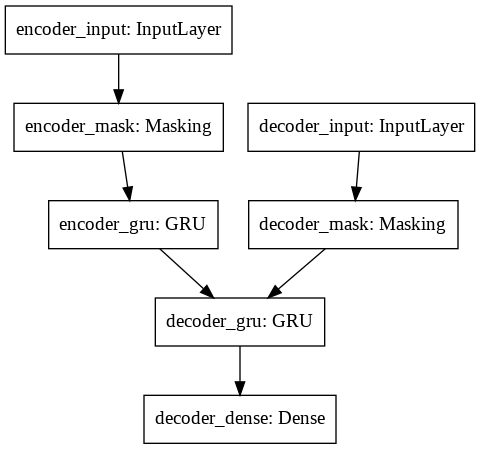

In [16]:
#モデルの構築
from tensorflow.keras.models  import Model
from tensorflow.keras.layers import Dense, GRU, Input, Masking


encoder_input = Input(shape=(None,n_char),name="encoder_input")
encoder_mask = Masking(mask_value=0,name="encoder_mask")
encoder_masked = encoder_mask(encoder_input)
encoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_state=True,name="encoder_gru")  # 過学習を抑えるためdropoutを設定し、ニューロンをランダムに無効にする
encoder_output, encoder_state_h = encoder_lstm(encoder_masked)

#デコーダの作成
decoder_input = Input(shape=(None,n_char),name="decoder_input")
decoder_mask = Masking(mask_value = 0,name="decoder_mask")
decoder_masked = decoder_mask(decoder_input)
decoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True,name="decoder_gru")  # dropoutを設定

decoder_output, _ = decoder_lstm(decoder_masked, initial_state=encoder_state_h)  # encoderの状態を初期状態にする
decoder_dense = Dense(n_char, activation='softmax',name="decoder_dense")
decoder_output = decoder_dense(decoder_output)

#モデル生成
model = Model([encoder_input, decoder_input], decoder_output)
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
print(model.summary())

#作成したモデルを可視化する
tf.keras.utils.plot_model(model, to_file='model.png')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping ,ModelCheckpoint


# val_lossに改善が見られなくなってから、30エポックで学習は終了
early_stopping = EarlyStopping(monitor="val_loss", patience=30) 

# チェックポイントコールバックを作る
checkpoint_path = "./drive/My Drive/ColabData/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


#訓練用とテスト用で分ける
x_encoder_train = x_encoder[0:25000]
x_decoder_train = x_decoder[0:25000]
t_decoder_train = t_decoder[0:25000]

x_encoder_test = x_encoder[25001:]
x_decoder_test = x_decoder[25001:]
t_decoder_test = t_decoder[25001:]


#すでに作成済みのモデルが有るかチェックする
if(os.path.exists(checkpoint_dir) == True):
  print("モデル読み込みを試みる:" + checkpoint_path)
  try:
    model.load_weights(checkpoint_path)
    model.summary();
    loss, acc = model.evaluate([x_encoder_test, x_decoder_test],  t_decoder_test, verbose=1)
    print("重みの読み込み完了")
    print(loss, acc)
  except Exception as e:
    print(e)
 

cp_callback = ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit([x_encoder_train, x_decoder_train], t_decoder_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.1,  # 10%は検証用
                     callbacks=[early_stopping, cp_callback])

loss, acc = model.evaluate([x_encoder_test, x_decoder_test],  t_decoder_test, verbose=2)
loss,acc

Epoch 1/10
704/704 [==============================] - ETA: 0s - loss: 1.1331 - accuracy: 0.2664
Epoch 00001: saving model to ./drive/My Drive/ColabData/training_1/cp.ckpt
704/704 [==============================] - 141s 201ms/step - loss: 1.1331 - accuracy: 0.2664 - val_loss: 1.2660 - val_accuracy: 0.3190
Epoch 2/10
704/704 [==============================] - ETA: 0s - loss: 0.9182 - accuracy: 0.3715
Epoch 00002: saving model to ./drive/My Drive/ColabData/training_1/cp.ckpt
704/704 [==============================] - 138s 196ms/step - loss: 0.9182 - accuracy: 0.3715 - val_loss: 1.1258 - val_accuracy: 0.3882
Epoch 3/10
660/704 [===========================>..] - ETA: 8s - loss: 0.8464 - accuracy: 0.4075

In [ ]:
#model = Model([encoder_input, decoder_input], decoder_output)
#model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
#loss, acc = model.evaluate([x_encoder_test, x_decoder_test],  t_decoder_test, verbose=2)

#model = Model([encoder_input, decoder_input], decoder_output)
#model.load_weights(checkpoint_path)
#model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
#loss, acc = model.evaluate([x_encoder_test, x_decoder_test],  t_decoder_test, verbose=2)
#print(loss, acc)



In [ ]:
#モデルを保存しておく
model.save('./drive/My Drive/ColabData/model.h5')


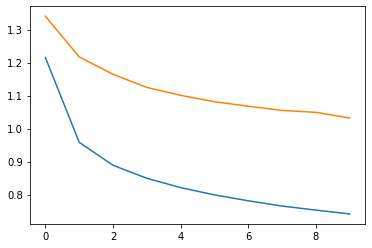

In [ ]:
#学習のグラフを描画する
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(val_loss)), val_loss)
plt.show()

In [ ]:
#こちらでは翻訳のためのモデルを作成する
#ポイントは、すでに作成済みのモデルを使用するため

# encoderのモデル
encoder_model = Model(encoder_input, encoder_state_h)

# decoderのモデル
decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h]

decoder_output, decoder_state_h = decoder_lstm(decoder_input,
                                               initial_state=decoder_state_in_h)
decoder_output = decoder_dense(decoder_output)

decoder_model = Model([decoder_input] + decoder_state_in,
                      [decoder_output, decoder_state_h])

# モデルの保存
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')


tf.keras.utils.plot_model(encoder_model, to_file='model1.png')
tf.keras.utils.plot_model(decoder_model, to_file='model2.png')

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None, 2080)] 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
decoder_gru (GRU)               [(None, None, 256),  1794816     decoder_input[0][0]              
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
decoder_dense (Dense)           (None, None, 2080)   534560      decoder_gru[1][0]          

In [ ]:
def respond(input_data, beta=5):
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, n_char))  # decoderの出力を格納する配列
    y_decoder[0][0][char_indices["\t"]] = 1  # decoderの最初の入力はタブ。one-hot表現にする。

    respond_sentence = ""  # 返答の文字列
    while True:
        y, h = decoder_model.predict([y_decoder, state_value])
        p_power = y[0][0] ** beta  # 確率分布の調整
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power)) 
        next_char = indices_char[next_index]  # 次の文字

        if (next_char == "\n" or len(respond_sentence) >= jp_max_length): 
            break  # 次の文字が改行のとき、もしくは最大文字数を超えたときは終了
            
        respond_sentence += next_char
        y_decoder = np.zeros((1, 1, n_char))  # 次の時刻の入力
        y_decoder[0][0][next_index] = 1

        state_value = h  # 次の時刻(文字)の状態

    return respond_sentence

In [ ]:
#実際に英語から日本語に翻訳をしてみる
#10回ほどのエポック数だと、訓練が少ないのか意味不明な日本語に翻訳されてしまうようだ。
for i in range(50):  
    x_in = x_encoder[i:i+1]  # 入力。英文のx_inはone-hot表現になっている
    responce = respond(x_in,10)  # 返答
    print("Input:", en_datas[i])
    print("Response:", responce)
    print()

Input: go.
Response: お願いします。

Input: go.
Response: お願いします。

Input: hi.
Response: はいつものがある。

Input: hi.
Response: はありません。

Input: hi.
Response: はいつものがある。

Input: run.
Response: 私には私には私には私に。

Input: run.
Response: 私には私には私には私に。

Input: who?
Response: あなたのお父さんは何ですか。

Input: wow!
Response: お願いします。

Input: wow!
Response: お願いします。

Input: wow!
Response: おいで。

Input: fire!
Response: お願いします。

Input: fire!
Response: お願いします。

Input: fire!
Response: お願いします。

Input: help!
Response: おい、おいで。

Input: jump!
Response: 起きなさい。

Input: jump!
Response: 起きなさい。

Input: jump!
Response: 起きなさい。

Input: jump!
Response: 起きなさい。

Input: jump!
Response: 起きなさい。

Input: jump.
Response: ちょっと待って。

Input: jump.
Response: ちょっと待って。

Input: jump.
Response: ちょっと待って。

Input: stop!
Response: やめろ！

Input: stop!
Response: やめろ！

Input: wait!
Response: 起きなさい。

Input: go on.
Response: お願いします。

Input: go on.
Response: お願いします。

Input: go on.
Response: お願いします。

Input: go on.
Response: お願いします。

Input: hello!
Response: おいついて。

Input: hell